# Pràctica 2: Classificació

- Grup: GPA305-1030 Compossat per: Jorge Giménez, Juan Cralos Soriano i Roger Boadella (1493035, XXXXXX, XXXXXXX)
- Link al dataset 1 (Apartat B): https://www.kaggle.com/kyr7plus/emg-4
- Link al dataset 2 (Apartat A): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

## Apartat B: Classificació Numèrica

#### 1. Imports i preprocessament de les dades

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
columns = []
for readingIdx in range(1,9):
    for sensorIdx in range(1, 9):
        columns.append(f'r{readingIdx}-s{sensorIdx}')
columns.append('gesture')
data = pd.DataFrame(columns=columns)

dataset_path = "./data/"
dataset_files = ["0", "1", "2", "3"]
for file in dataset_files:
    df = pd.read_csv(f'{dataset_path}{file}.csv', names=columns)
    data = data.append(df)

El dataset ve donat en 4 fitxers csv, el que fem en aquest bloc de codi és junta-los tots en un sol dataset així com donar uns noms més pràctics a les columnes. De totes maneres, l'estructura del dataset serà explicada a continuació.

#### 2. Explanatory Data Analysis

El nostre dataset tracta de diferents gests que es fan amb una mà. Es col·loquen diferents sensors en una mà humana i es realitzen un total de 8 gests diferents. A la vegada hi ha 8 sensors diferents que fan lectures de l'activitat elèctrica produïda pels músculs amb una freqüència de 200Hz.  
Disposem de 65 columnes al dataset i un total d'11678 files. Les primeres 64 columnes són les 8 lectures consecutives que realitzen els 8 sensors en un temps de lectura de 20ms. En quant a l'última fila, aquesta conté l'etiqueta que ens diu quin gest està fent la mà per a cada conjunt de lectures. Aquesta etiqueta pot ser:  
- 0: Pedra
- 1: Paper
- 2: Tisores
- 3: OK  

Els noms de les columnes tenen el següent format r[X]-s[Y] on X és el número de lectura (1-8) i Y és el número del sensor (1-8).

In [3]:
data.head()

,r1-s1,r1-s2,r1-s3,r1-s4,r1-s5,r1-s6,r1-s7,r1-s8,r2-s1,r2-s2,...,r7-s8,r8-s1,r8-s2,r8-s3,r8-s4,r8-s5,r8-s6,r8-s7,r8-s8,gesture
0,26.000,4.000,5.000,8.000,-1.000,-13.000,-109.000,-66.000,-9.000,2.000,...,-28.000,61.000,4.000,8.000,5.000,4.000,-7.000,-59.000,16.000,0
1,-47.000,-6.000,-5.000,-7.000,13.000,-1.000,35.000,-10.000,10.000,-4.000,...,-25.000,47.000,6.000,6.000,5.000,13.000,21.000,111.000,15.000,0
2,-19.000,-8.000,-8.000,-8.000,-21.000,-6.000,-79.000,12.000,0.000,5.000,...,-83.000,7.000,7.000,1.000,-8.000,7.000,21.000,114.000,48.000,0
3,2.000,3.000,0.000,2.000,0.000,22.000,106.000,-14.000,-16.000,-2.000,...,-38.000,-11.000,4.000,7.000,11.000,33.000,39.000,119.000,43.000,0
4,6.000,0.000,0.000,-2.000,-14.000,10.000,-51.000,5.000,7.000,0.000,...,38.000,-35.000,-8.000,2.000,6.000,-13.000,-24.000,-112.000,-69.000,0


Tots els atributs contenen valors enters. N'hi ha de positius i n'hi ha de negatius.

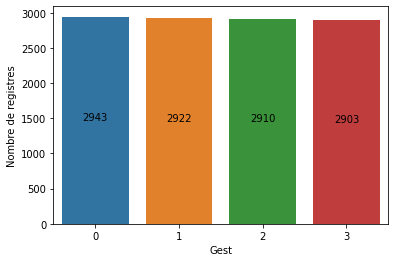

In [4]:
ax = sns.barplot(x=data['gesture'].unique(), y=data['gesture'].value_counts());
plt.xlabel("Gest");
plt.ylabel("Nombre de registres");
for p in ax.patches:
            _x = p.get_x()+p.get_width()/2
            _y = p.get_y()+p.get_height()/2
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

Tenim una distribució molt balancejada dels gests. 2943 registres per a la "pedra", 2922 per al "paper", 2910 per al "tisores" i 2903 per al "OK". Per tant, podem utilitzar l'accuracy per avaluar el nostre model, ja que totes les classes estan balancejades. A més, el modelo no hauria de desenvolupar 'bias' cap a cap de les classes.

In [5]:
nullValues = 0
for n in data.isna().sum():
    if n != 0: nullValues += 1
print(f'Nombre de "missing-values": {nullValues}')

Nombre de "missing-values": 0


No hi ha "missing-values" a cap lloc, cosa positiva ja que així no els hem de tractar de cpa manera.

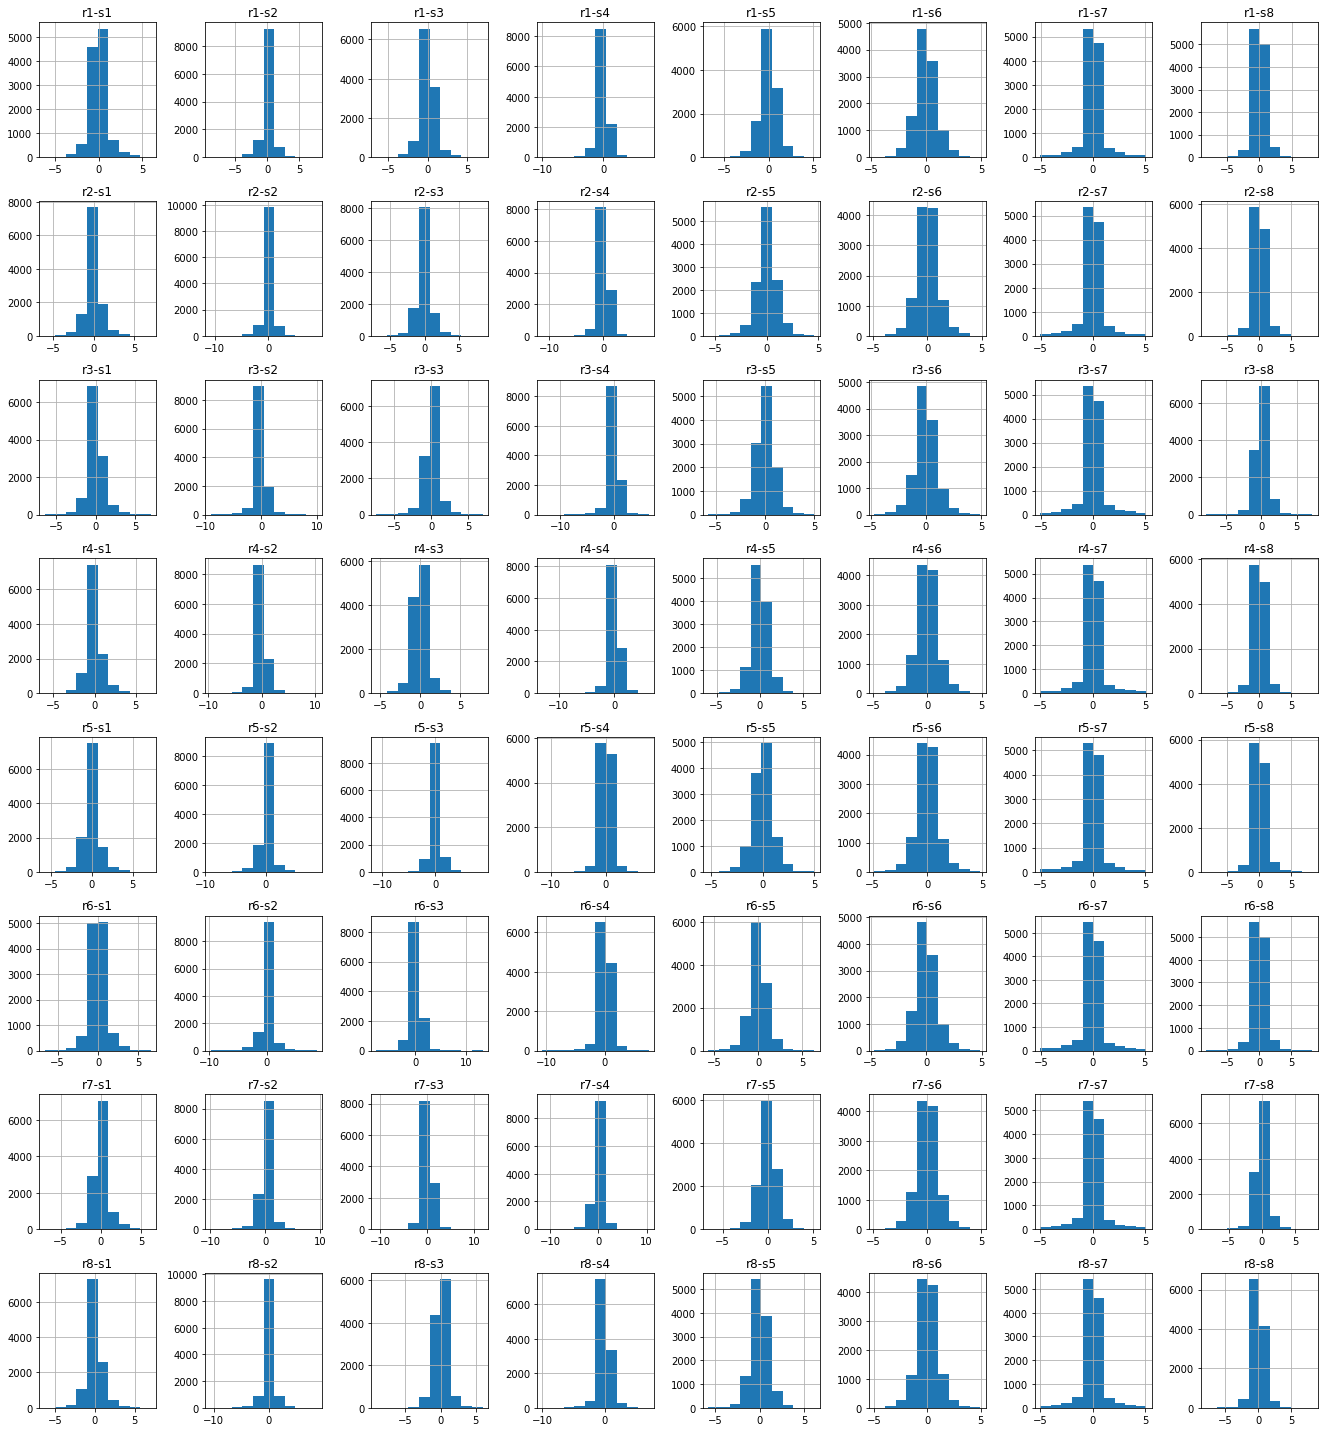

In [15]:
data.hist();
fig = plt.gcf()
fig.set_size_inches(18.5, 20)
plt.tight_layout()

Totes les lectures de tots els sensors tenen distribucions més o menys sembalnts, però pdoem observar com el rang de valors d'alguns sensors són més grans que els d'altres, per tant no està de més normalitzar aquestes dades més endevant.

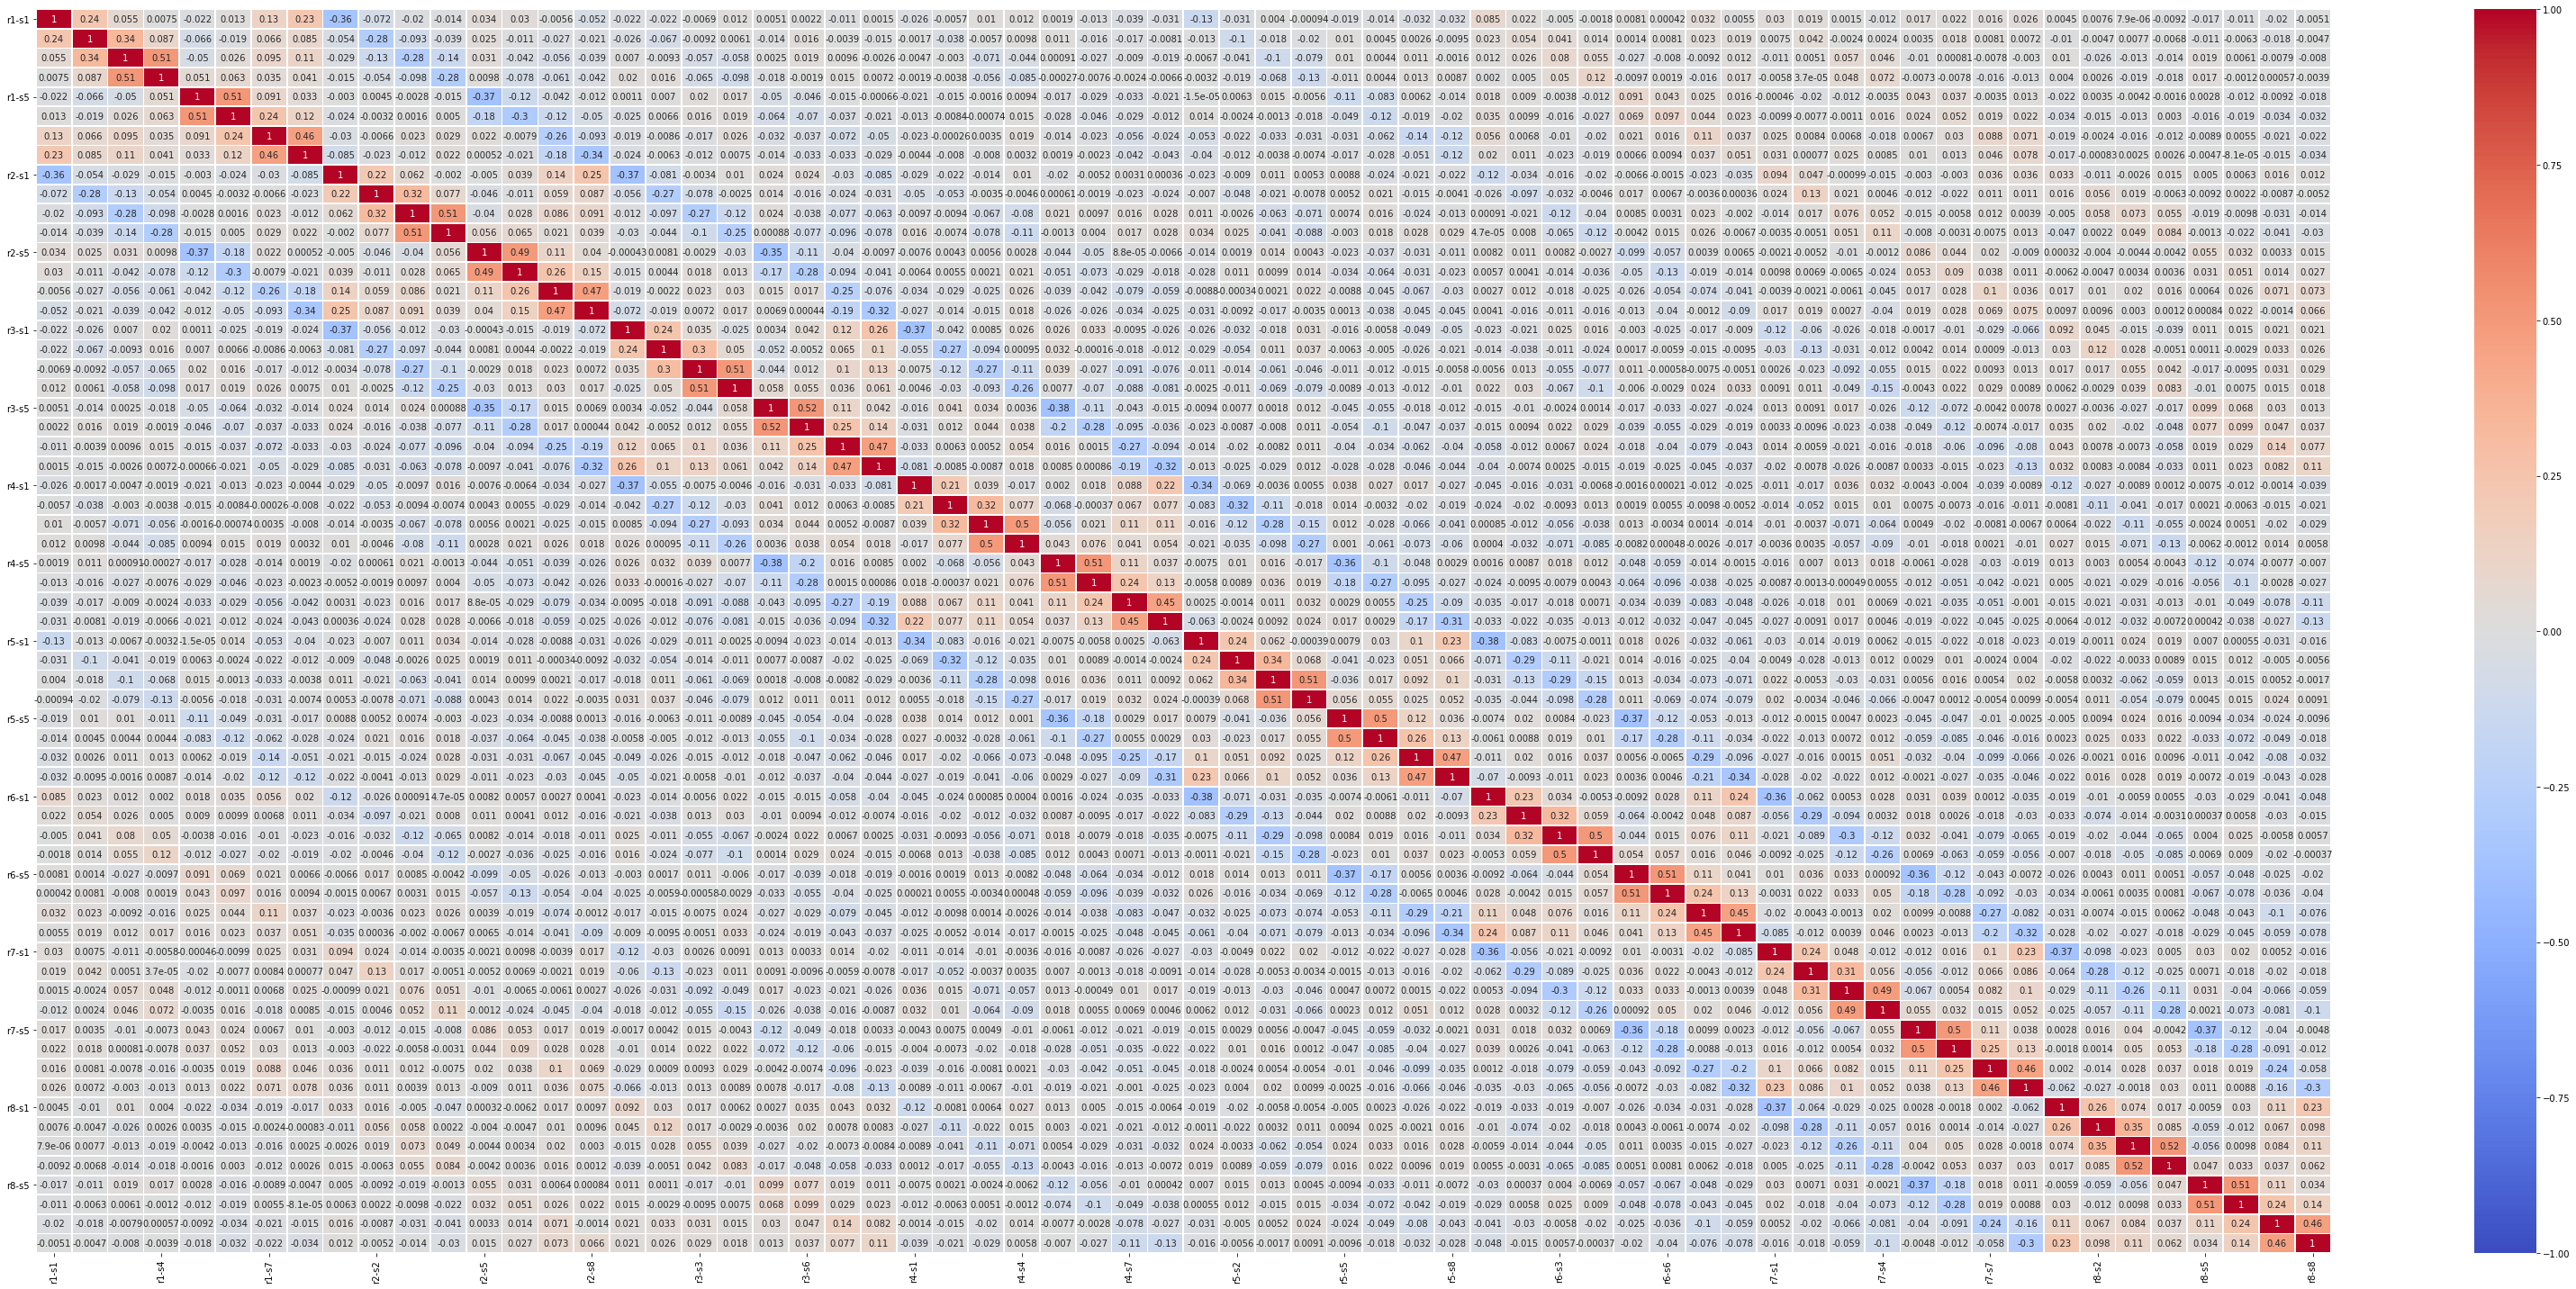

In [20]:
sns.heatmap(data.corr(), annot=True, linewidths= .75, vmin=-1, vmax=1, cmap='coolwarm');
fig = plt.gcf()
fig.set_size_inches(45, 20)
plt.tight_layout();

No observem correlacions massa destacables entre les diferents lectures. En alguns casos hi ha una lleugera correlació entre les lectures consecutives dels sensors i també s'observa una certa correlació entre les lectures dels sensors consecutius, però res que pugui afectar massa la classificació des del nostre punt de vista.

#### 3. Preprocessing

Com hem dit a la secció anterior, seria recomanable normalitzar o estandarditzar les dades. Donat que com hem pogut veure totes les columnes tenen distribucions molt semblants optarem per estandarditzar les dades.

In [18]:
standarizer = StandardScaler()
data[data.columns[:-1]] = standarizer.fit_transform(data.iloc[:,:-1])

In [19]:
data.describe()

,r1-s1,r1-s2,r1-s3,r1-s4,r1-s5,r1-s6,r1-s7,r1-s8,r2-s1,r2-s2,...,r7-s7,r7-s8,r8-s1,r8-s2,r8-s3,r8-s4,r8-s5,r8-s6,r8-s7,r8-s8
count,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,...,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000
mean,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-6.220,-8.777,-6.465,-9.981,-6.770,-4.706,-5.051,-8.264,-6.033,-10.755,...,-4.997,-8.383,-6.326,-10.601,-9.102,-9.926,-5.765,-4.995,-5.010,-7.946
25%,-0.457,-0.278,-0.453,-0.439,-0.551,-0.560,-0.188,-0.476,-0.460,-0.283,...,-0.173,-0.466,-0.448,-0.272,-0.449,-0.446,-0.552,-0.533,-0.180,-0.476
50%,-0.026,-0.023,-0.052,-0.036,0.009,-0.017,0.011,-0.022,-0.018,-0.029,...,0.025,-0.004,-0.009,-0.022,-0.047,-0.040,0.008,-0.024,0.018,-0.025
75%,0.405,0.317,0.549,0.501,0.569,0.525,0.210,0.432,0.368,0.309,...,0.183,0.457,0.376,0.312,0.557,0.502,0.569,0.523,0.176,0.426
max,6.007,7.711,6.962,7.489,5.163,4.942,5.113,8.220,7.044,9.007,...,5.086,7.582,7.023,8.808,5.990,7.002,6.174,4.985,5.085,8.217


Com hem vist abans, no hi ha 'missing-values', per tant no cal tractar-los. Respecte a les dades categòriques només tenim la columna 'gesture' que és, de fet, el que volem predir, per tant, tampoc hem de tractar-ho. El que sí que tenim és una quantitat raonablement gran de 64 atributs d'entrada que potser podríem intentar reduir. Tanmateix, hem pogut comprovar anteriorment que no hi ha correlacions massa fortes per tant no obtindríem millores considerables per aplicar un PCA.

---

↓↓↓ **SOLO PROBANDO, NO ES SERIO!** ↓↓↓

In [28]:
train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.33, random_state=42)

In [50]:
train_y.value_counts()

2    1996
3    1969
0    1947
1    1912
Name: gesture, dtype: int64

In [51]:
test_y.value_counts()

1    991
0    963
3    953
2    947
Name: gesture, dtype: int64

In [37]:
svc = SVC()
svc.fit(train_x, train_y.astype('int'))
predictions = svc.predict(test_x)

In [43]:
print(classification_report(test_y.astype('int'), predictions.astype('int')))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       963
           1       0.87      0.98      0.92       991
           2       0.93      0.84      0.88       947
           3       0.85      0.84      0.84       953

    accuracy                           0.89      3854
   macro avg       0.89      0.89      0.89      3854
weighted avg       0.89      0.89      0.89      3854

